<a href="https://colab.research.google.com/github/ebceran/case_control_sampling/blob/main/case_control_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Real default rate: 0.025
Sampled default rate: 0.5

Model coefficients (from sampled data):
Age: 0.06056365154464593
Income: 0.000642786858343058
Late Payments: -3.1686395243319567
Intercept (biased): -3.9566105736167274

Corrected intercept: -7.620172219746374


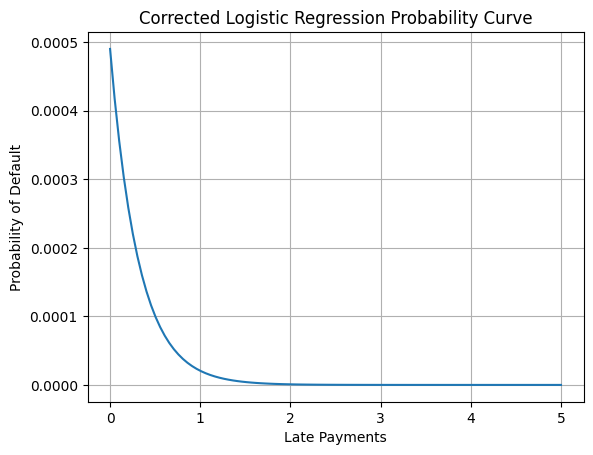

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# ---------- 1. CREATE IMBALANCED SYNTHETIC DATA ---------- #

np.random.seed(42)
n = 5000   # total customers

# Features
age = np.random.randint(18, 70, n)
income = np.random.randint(1500, 7000, n)
late = np.random.randint(0, 6, n)

# True default rate in real life (2%)
true_default_prob = (
    -0.03 * age
    - 0.0003 * income
    + 1.8 * late
    + np.random.normal(0, 1, n)
)

p = 1 / (1 + np.exp(-true_default_prob))

y = (p < 0.02).astype(int)   # only 2% default

df = pd.DataFrame({"age": age,
                   "income": income,
                   "late": late,
                   "default": y})

print("Real default rate:", df['default'].mean())


# ---------- 2. CASE–CONTROL SAMPLING ---------- #

cases = df[df['default'] == 1]          # all default customers
controls = df[df['default'] == 0].sample(len(cases), random_state=42)

sampled_df = pd.concat([cases, controls])

print("Sampled default rate:", sampled_df['default'].mean())


# ---------- 3. TRAIN LOGISTIC REGRESSION ON THE SAMPLED DATA ---------- #

model = LogisticRegression()
model.fit(sampled_df[['age', 'income', 'late']], sampled_df['default'])

coef = model.coef_[0]
intercept = model.intercept_[0]

print("\nModel coefficients (from sampled data):")
print("Age:", coef[0])
print("Income:", coef[1])
print("Late Payments:", coef[2])
print("Intercept (biased):", intercept)


# ---------- 4. ADJUST INTERCEPT FOR SAMPLING BIAS ---------- #

# True default rate in real data
pi = df['default'].mean()

# Default rate in sampled training data
q = sampled_df['default'].mean()

# Bias correction (Stanford formula)
corrected_intercept = intercept + np.log(pi/(1-pi)) - np.log(q/(1-q))

print("\nCorrected intercept:", corrected_intercept)


# ---------- 5. VISUALIZE THE EFFECT OF 'LATE PAYMENTS' ---------- #

x_plot = np.linspace(0, 5, 100)

# using corrected intercept
score = corrected_intercept + coef[2] * x_plot
prob_plot = 1 / (1 + np.exp(-score))

plt.plot(x_plot, prob_plot)
plt.xlabel("Late Payments")
plt.ylabel("Probability of Default")
plt.title("Corrected Logistic Regression Probability Curve")
plt.grid(True)
plt.show()
